In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import seaborn as sns
from pre_processing_functions import *
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
%load_ext autoreload
%autoreload 2

In [3]:
df = pd.read_csv('customer_info.csv')
df = feature_transformation(df)
df = missing_values(df)


In [4]:
df

,customer_id,customer_name,customer_gender,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,...,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,customer_age,years_active,customer_educlevel
0,29930.0,April Clark,1.0,2.0,2.0,1.0,4.0,7789.0,5601.0,13.0,...,428.0,386.0,15.874075,2018.0,0.0,38.721807,-9.125534,53.0,7.0,None
1,6813.0,Paul Ketchum,0.0,0.0,1.0,0.0,4.0,8653.0,35.0,14.0,...,226.0,73.0,122.789042,2013.0,1.0,38.734668,-9.163533,81.0,12.0,Bsc.
2,39451.0,Mary Downing,1.0,2.0,3.0,0.0,7.0,15605.0,4275.0,14.0,...,192.0,319.0,10.159789,2011.0,0.0,38.787126,-9.147077,36.0,14.0,None
3,21557.0,Manuel Kueny,0.0,0.0,0.0,1.0,1.0,13440.0,16366.0,14.0,...,270.0,221.0,25.994254,2009.0,0.0,38.741816,-9.159700,49.0,16.0,None
4,16415.0,Curtis Tharp,0.0,1.0,1.0,1.0,5.0,49250.0,3197.0,14.0,...,144.0,244.0,31.782174,2012.0,1.0,38.785921,-9.149221,59.0,13.0,Phd.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34055,37071.0,Mary Diaz,1.0,1.0,1.0,0.0,2.0,62321.0,5250.0,16.0,...,258.0,163.0,16.233149,2018.0,0.0,38.750813,-9.103808,26.0,7.0,None
34056,27422.0,John Gross,0.0,1.0,1.0,0.0,3.0,16084.0,3796.0,13.0,...,319.0,379.0,61.417938,2019.0,1.0,38.745020,-9.169168,41.0,6.0,None
34057,39540.0,Kathleen Harper,1.0,1.0,0.0,1.0,2.0,14631.0,8784.0,17.0,...,110.0,228.0,53.561736,2018.0,0.0,38.767834,-9.172368,25.0,7.0,None
34058,18367.0,Jenny Landry,1.0,1.0,1.0,1.0,4.0,37420.0,4702.0,9.0,...,376.0,151.0,43.501363,2015.0,1.0,38.732462,-9.156155,64.0,10.0,Msc.


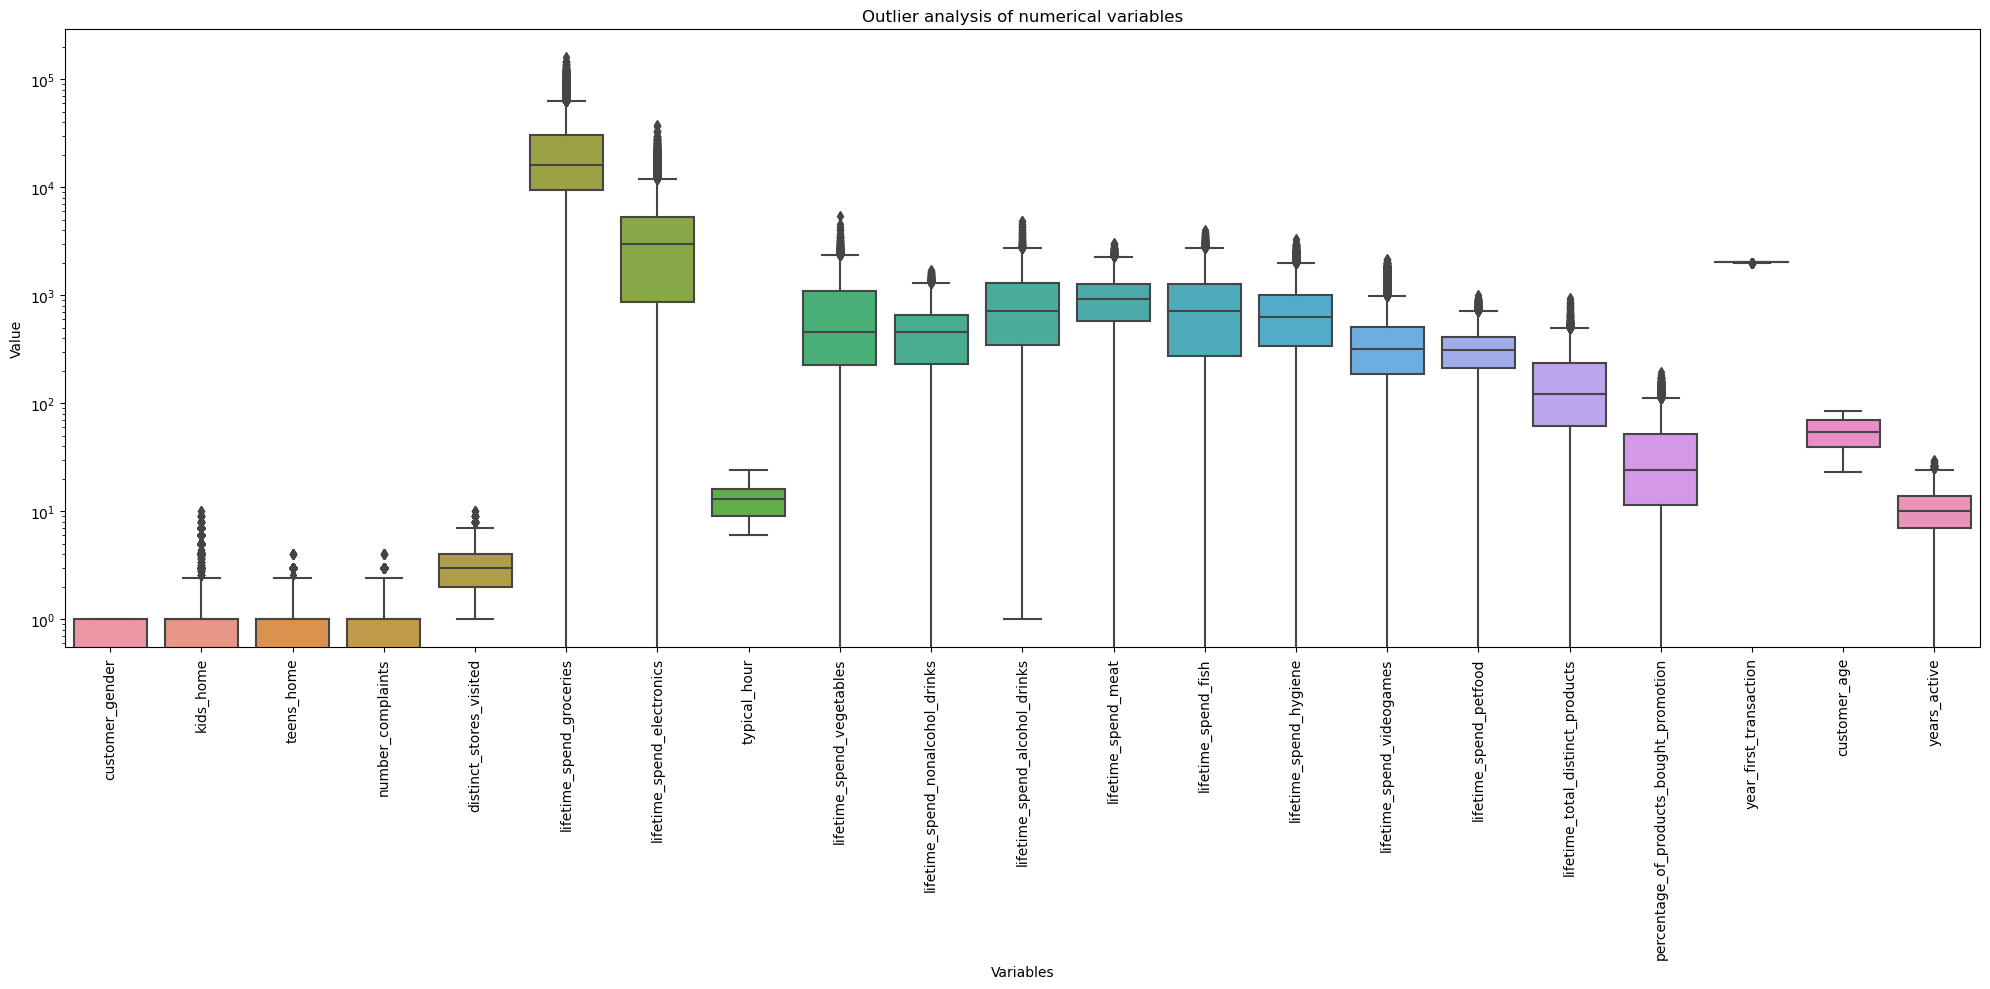

In [5]:
colunas_excluir = ['customer_id', 'loyalty_card_number', 'latitude', 'longitude']
df_new = df.drop(columns=[col for col in colunas_excluir if col in df.columns])

df_numerico = df_new.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_numerico, orient='v')
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Outlier analysis of numerical variables')
plt.ylabel('Value')
plt.xlabel('Variables')
plt.tight_layout()
plt.show()

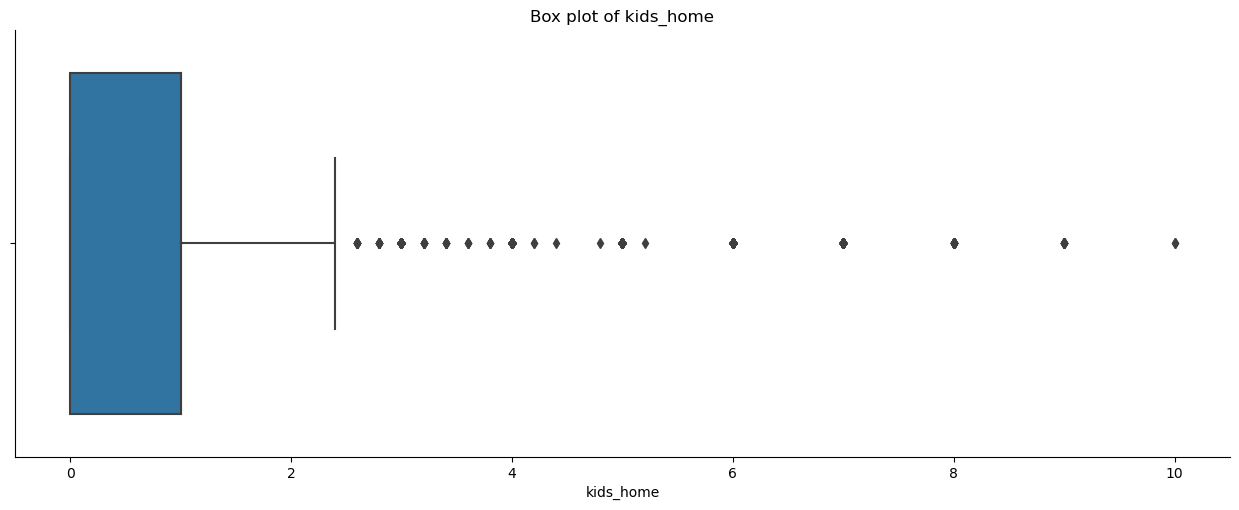

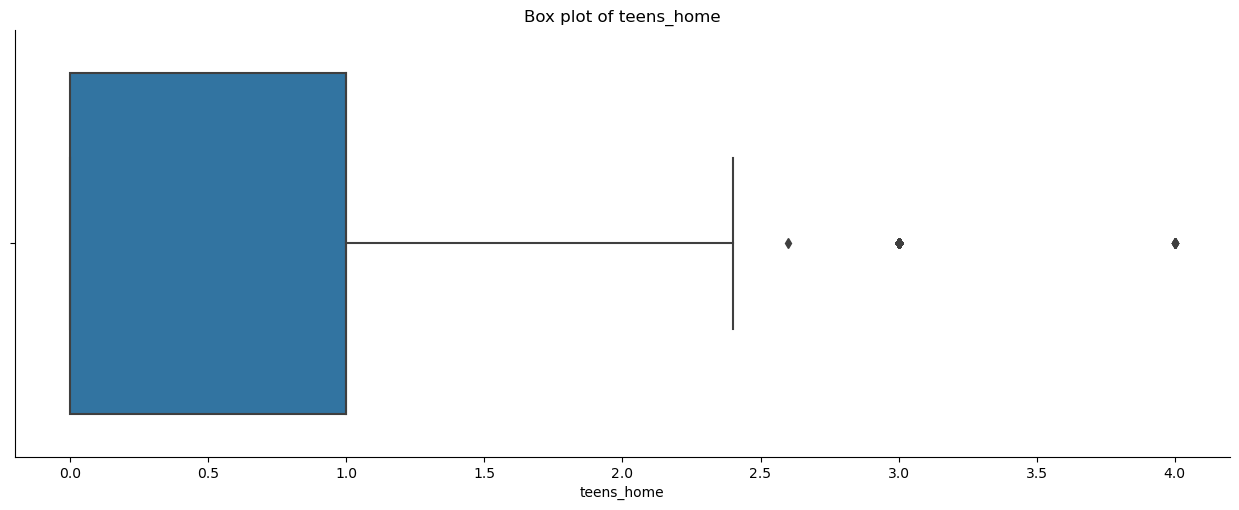

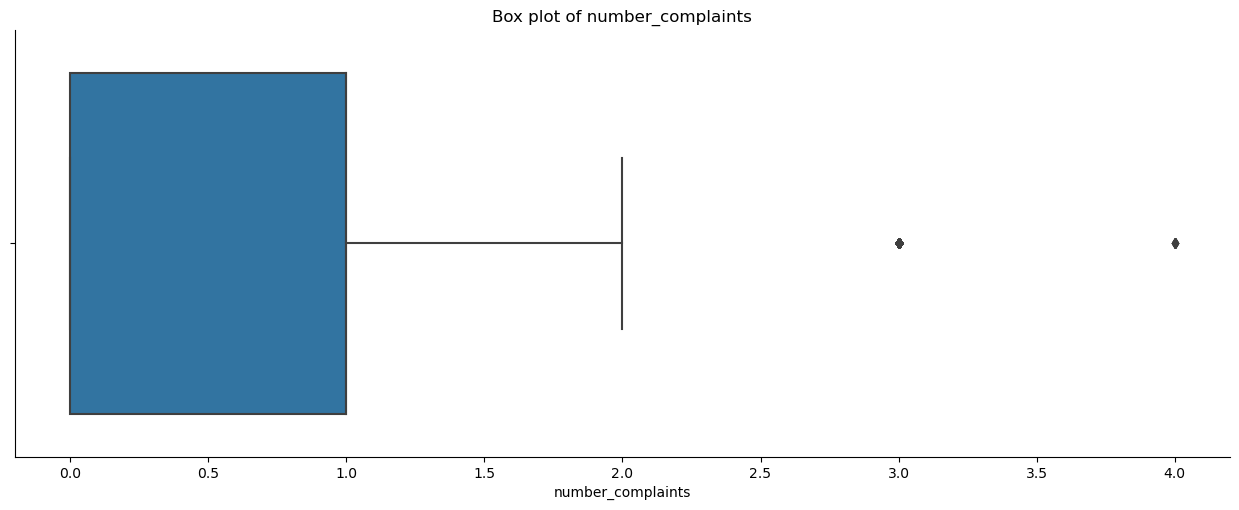

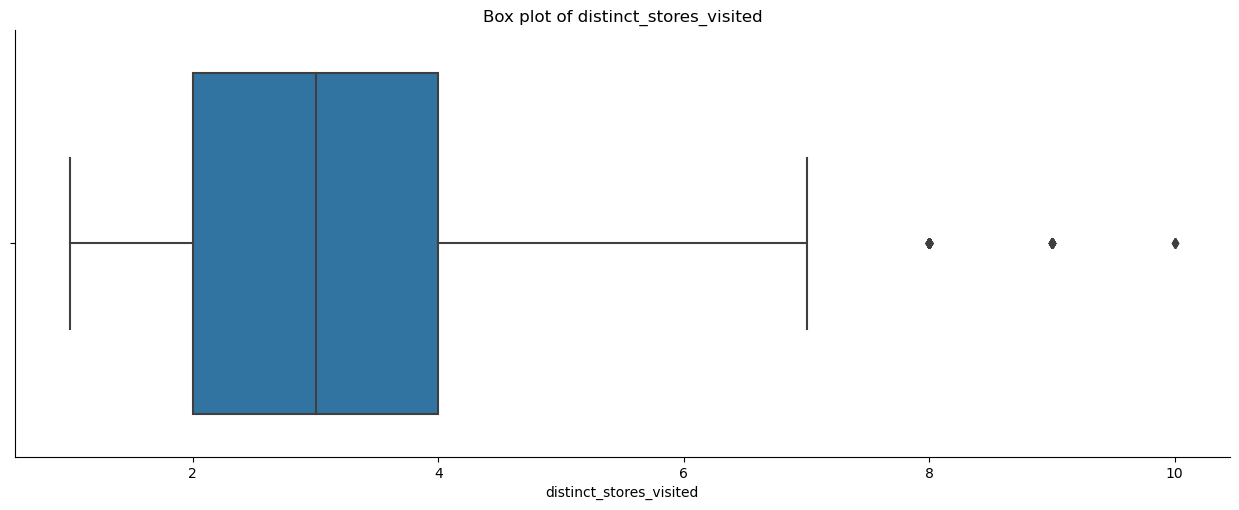

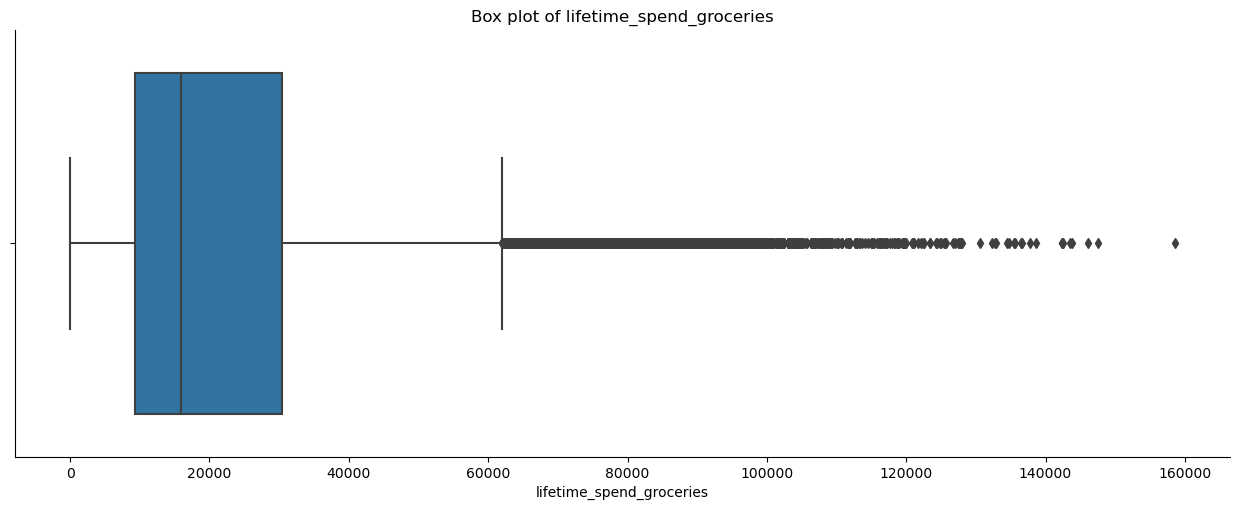

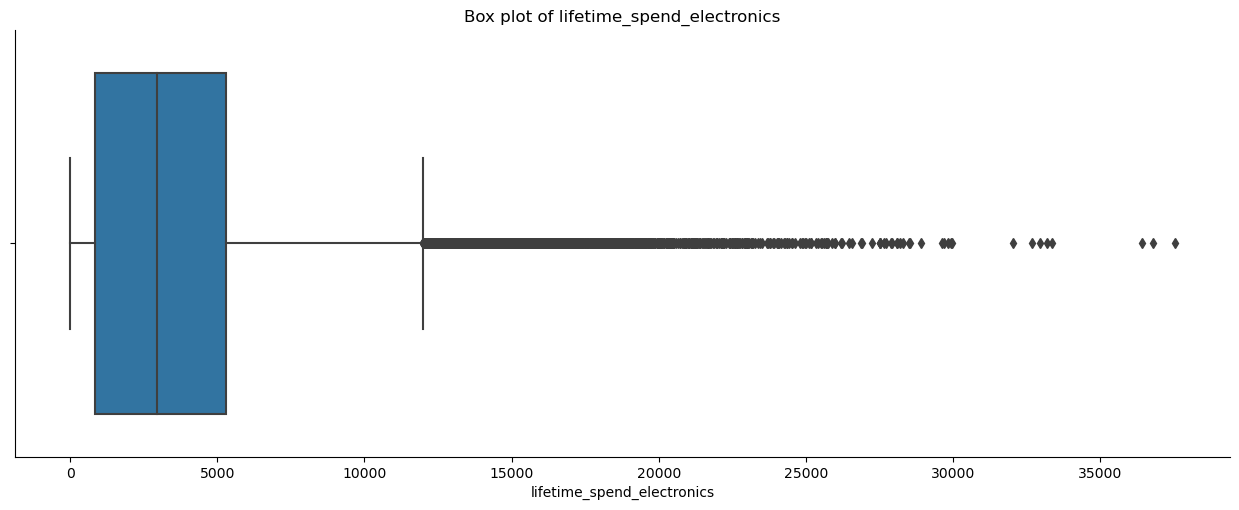

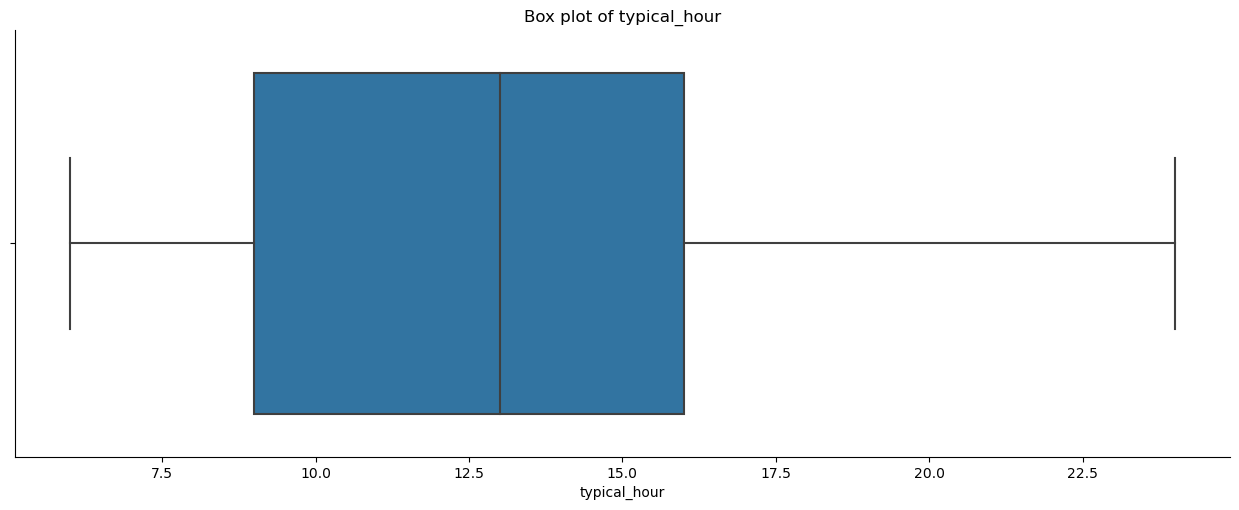

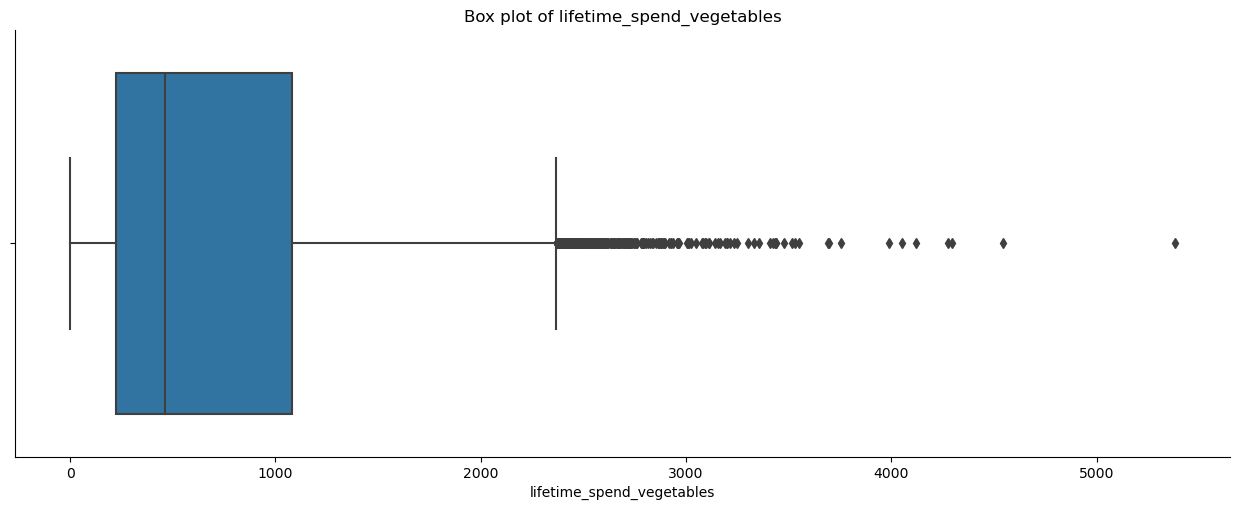

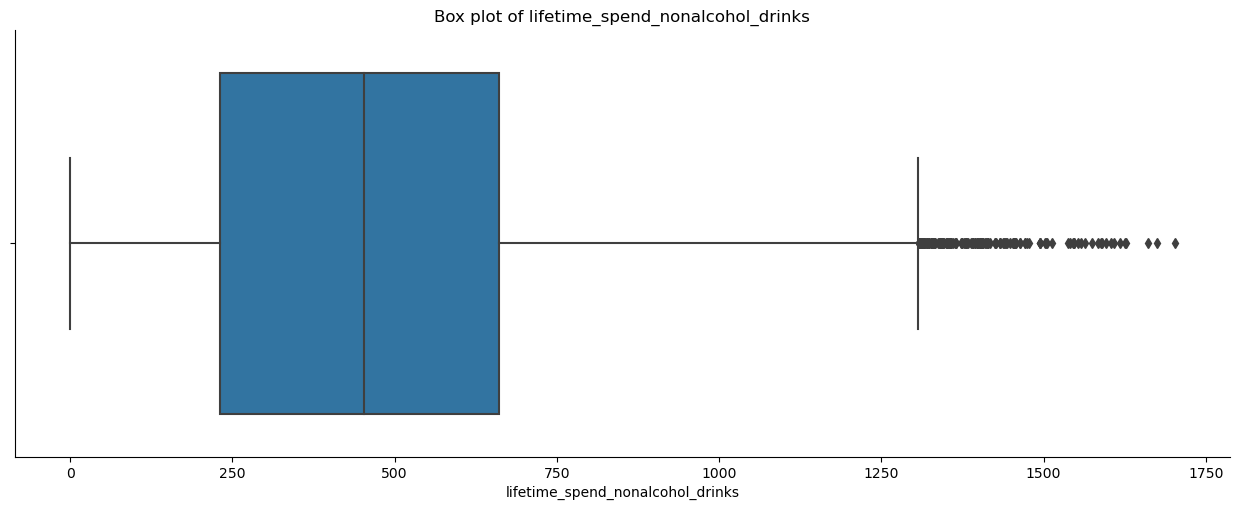

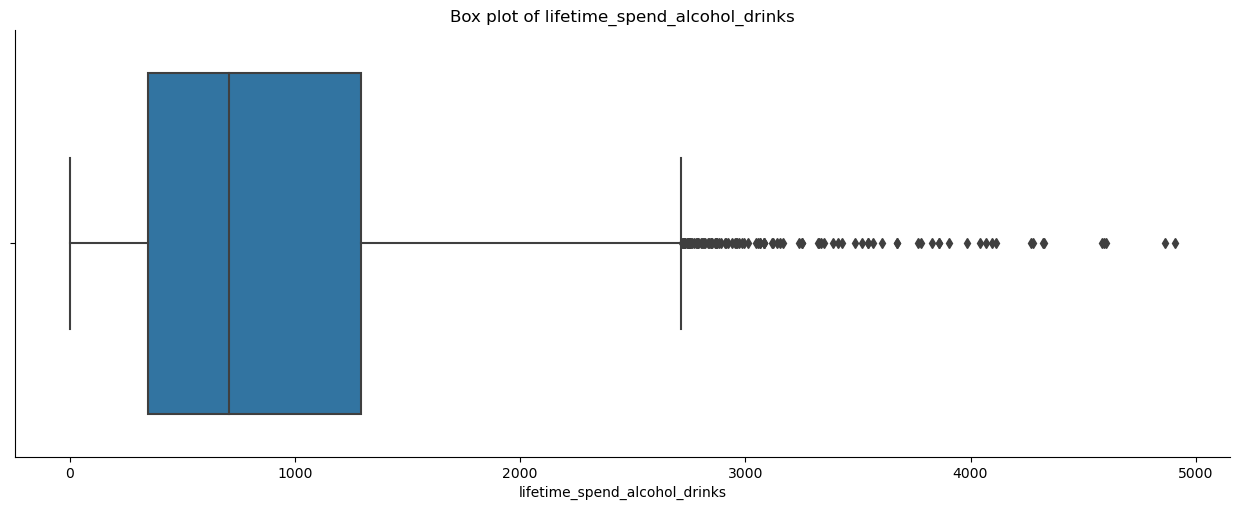

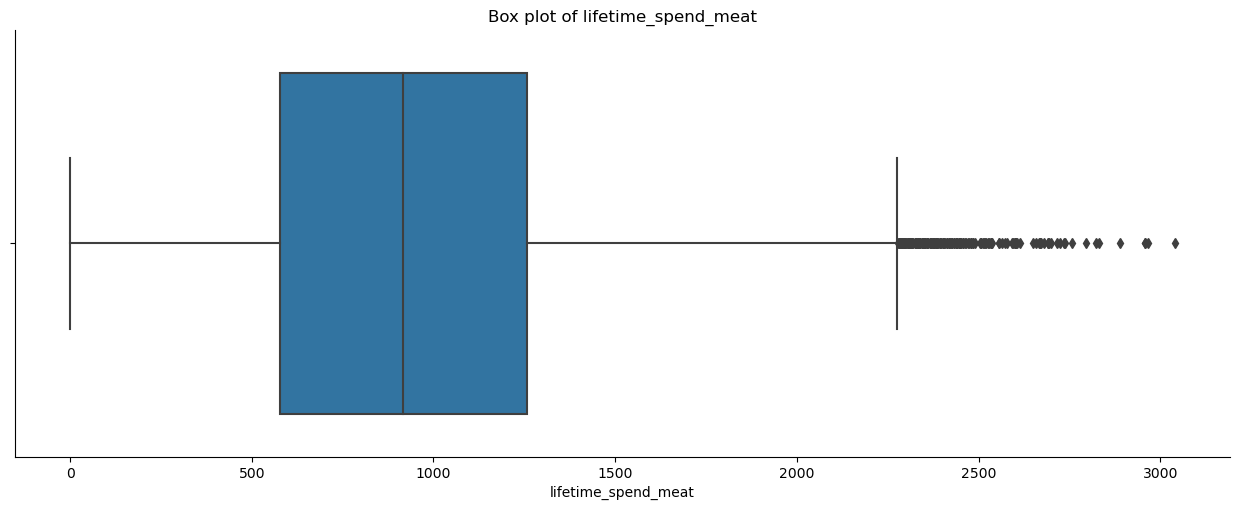

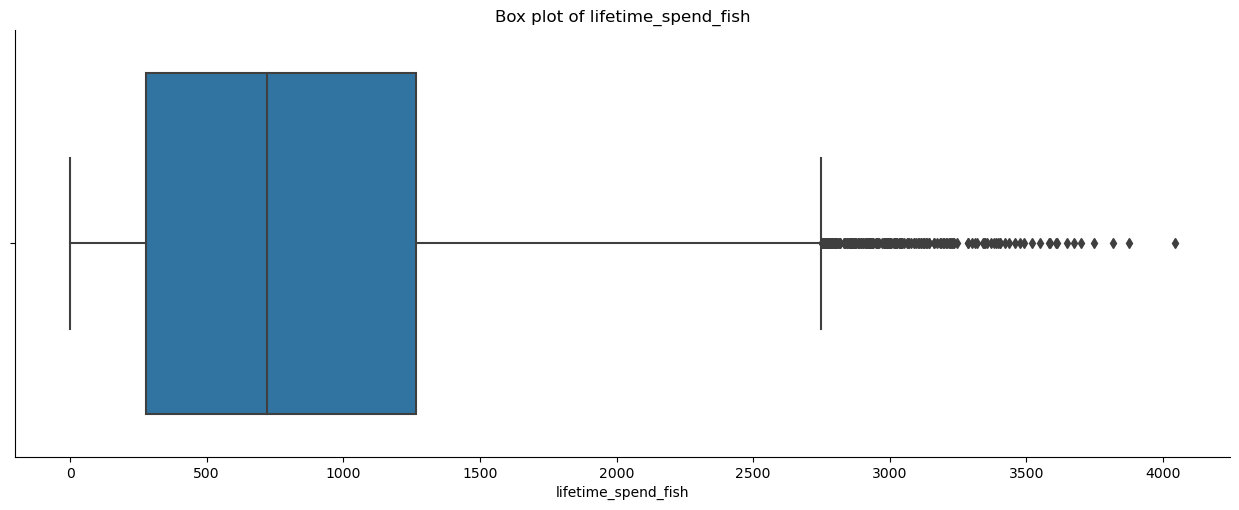

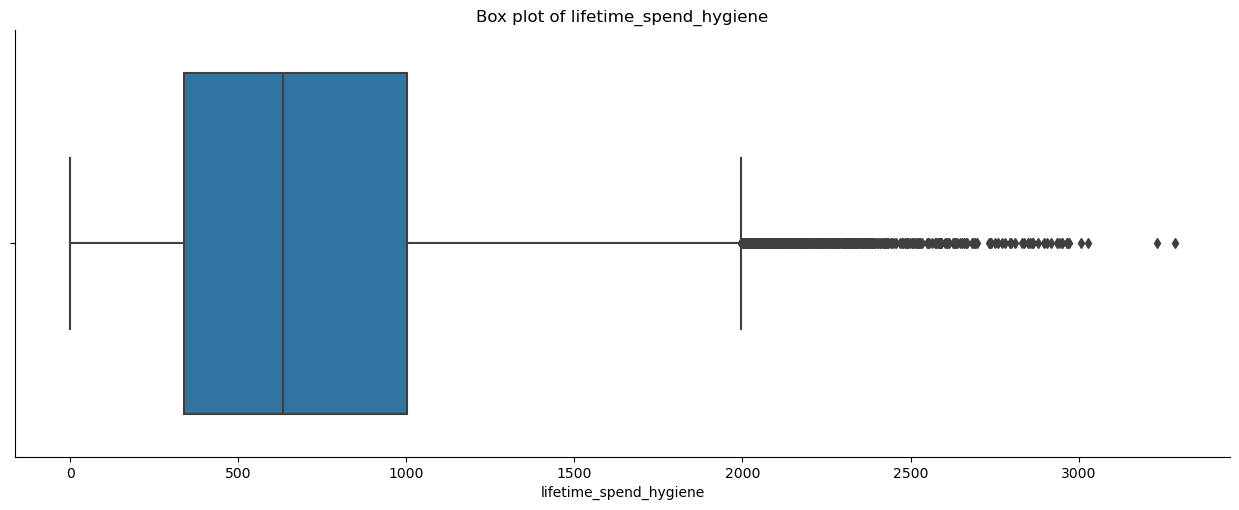

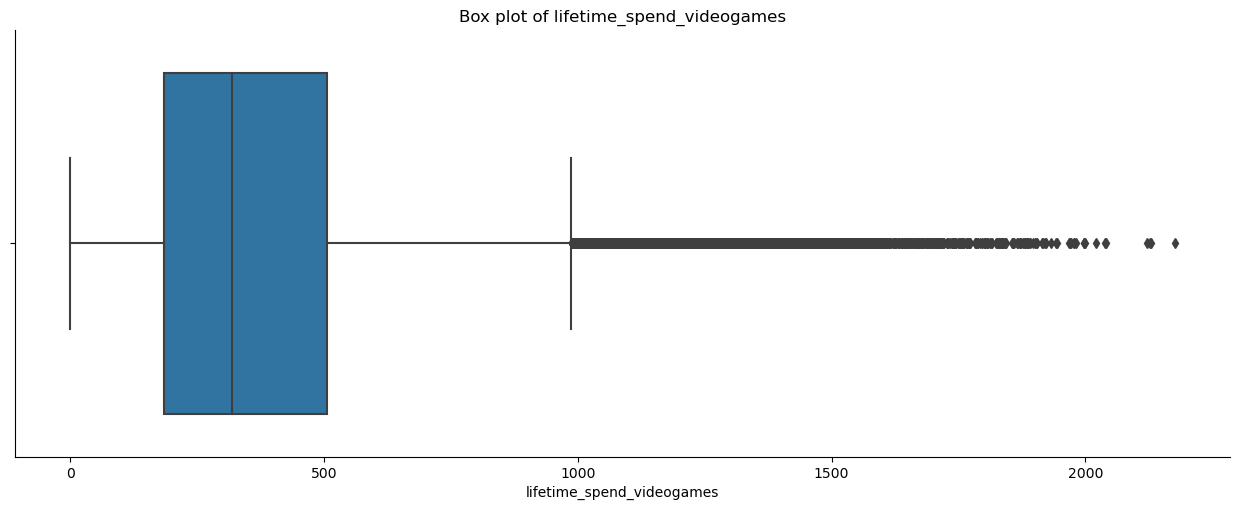

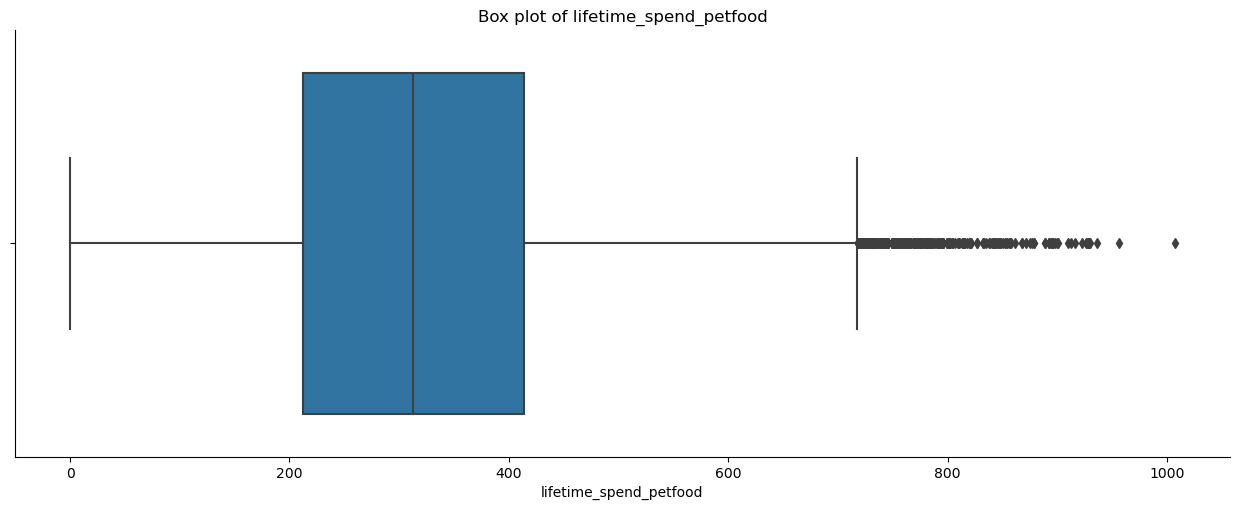

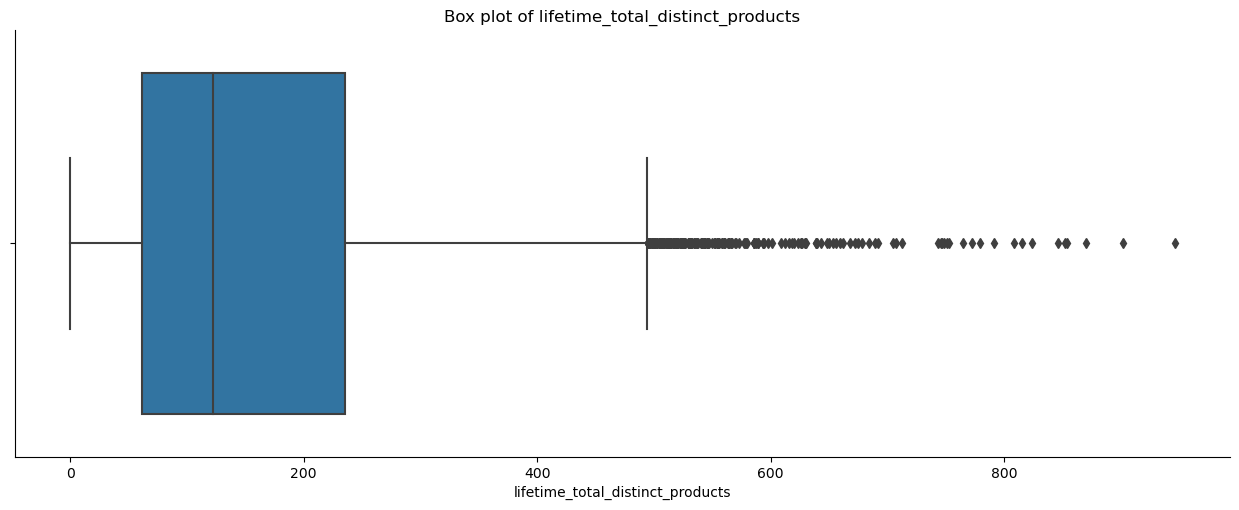

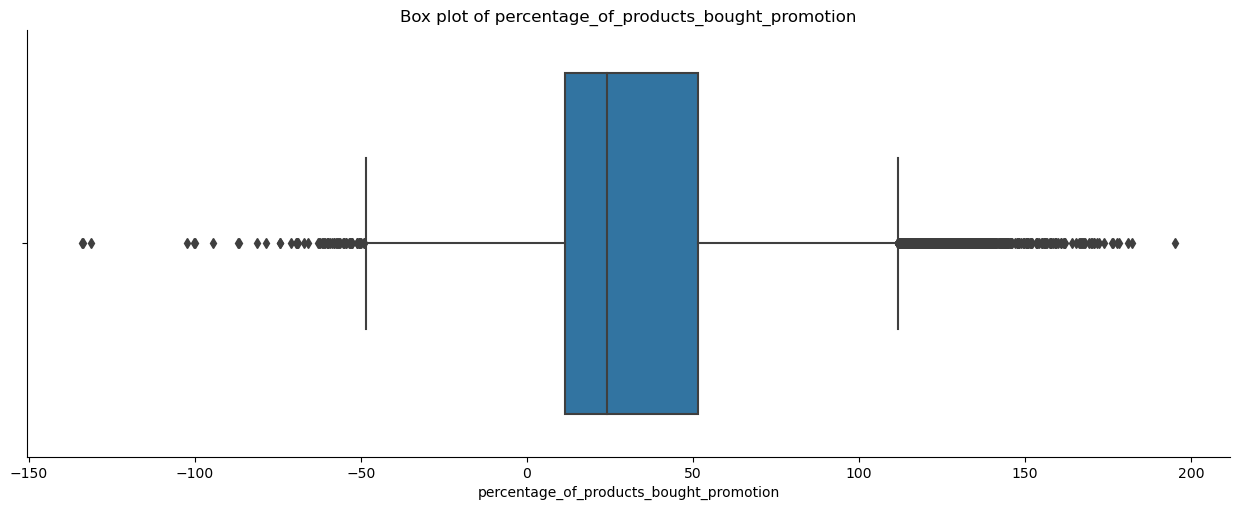

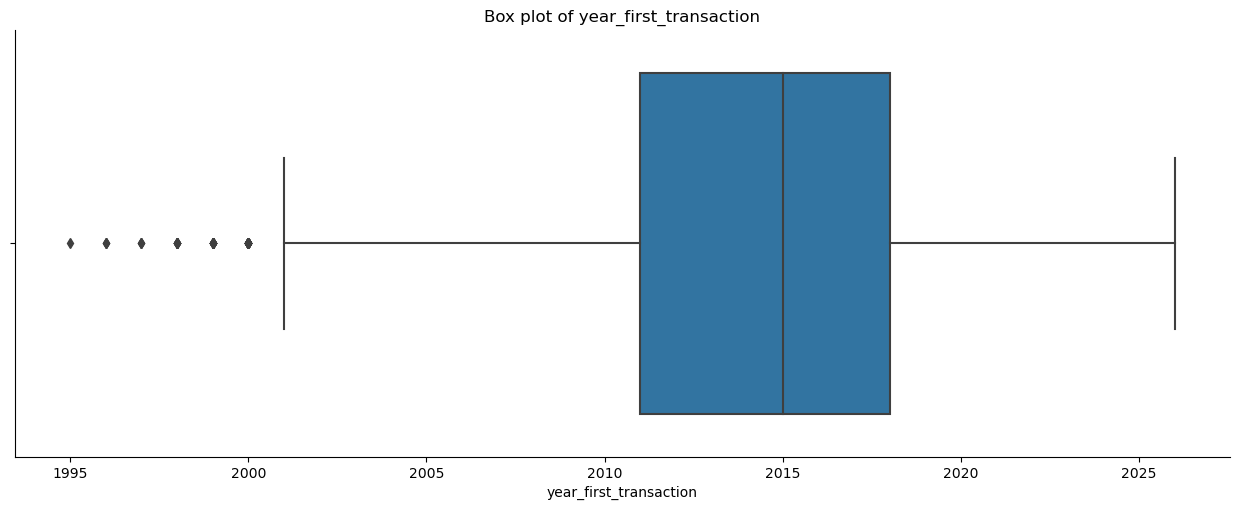

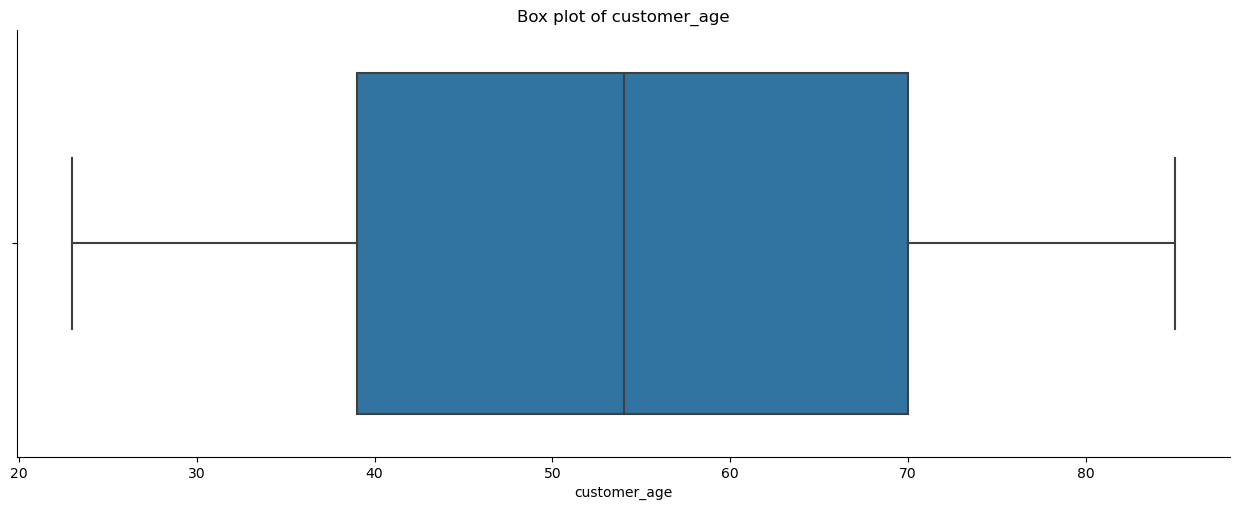

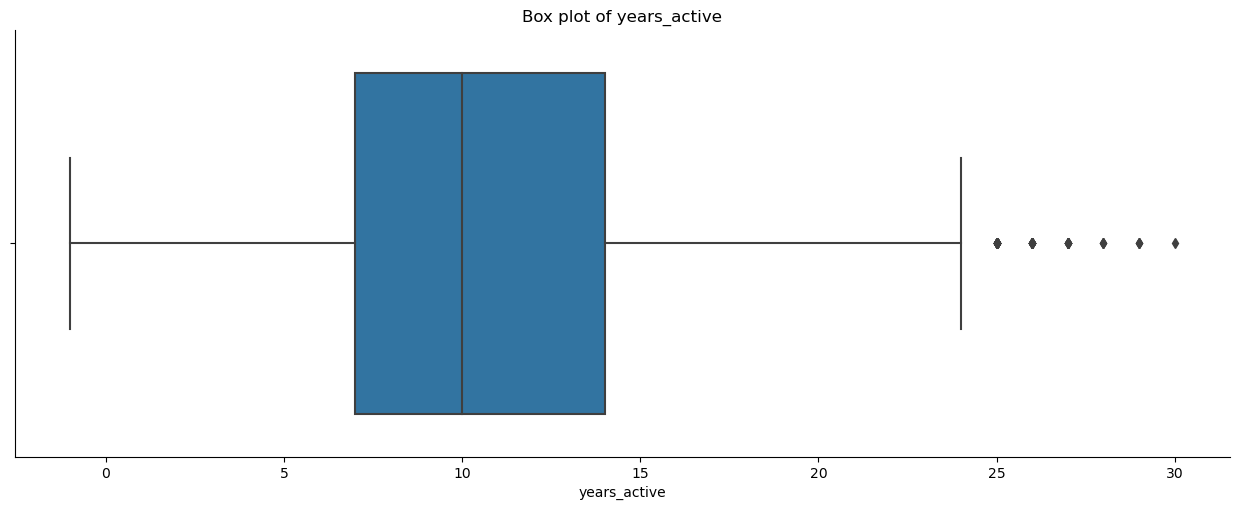

In [6]:
for var in df.describe().columns.drop(['customer_id', 'customer_gender','loyalty_card_number','latitude', 'longitude']):
    sns.catplot(data=df, x=var, kind='box', height=5, aspect=2.5)
    plt.title(f'Box plot of {var}')
    plt.show()

<b> Unidimensional outliers

Manual thresholding: <br>
To avoid removing too many data when dealing with outliers, we decided to just performe a manual thresholding<br>
-Percentage of products bought in promotion - todas negativas passar a zero <br>
-Life time spents - tetos nao muito fortes 

In [7]:
df.columns

Index(['Unnamed: 0', 'customer_id', 'customer_name', 'customer_gender',
       'customer_birthdate', 'kids_home', 'teens_home', 'number_complaints',
       'distinct_stores_visited', 'lifetime_spend_groceries',
       'lifetime_spend_electronics', 'typical_hour',
       'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks',
       'lifetime_spend_alcohol_drinks', 'lifetime_spend_meat',
       'lifetime_spend_fish', 'lifetime_spend_hygiene',
       'lifetime_spend_videogames', 'lifetime_spend_petfood',
       'lifetime_total_distinct_products',
       'percentage_of_products_bought_promotion', 'year_first_transaction',
       'loyalty_card_number', 'latitude', 'longitude', 'customer_age',
       'years_active', 'customer_educlevel'],
      dtype='object')

In [8]:
def manual_outliers(df):
    manual_thresholds = {
        'lifetime_spend_groceries': 140000,
        'lifetime_spend_electronics': 30000,
        'lifetime_spend_vegetables': 4000,
        'lifetime_spend_nonalcohol_drinks': 1600,
        'lifetime_spend_alcohol_drinks': 4000,
        'lifetime_spend_meat': 2800,
        'lifetime_spend_fish': 3600,
        'lifetime_spend_hygiene': 3000,
        'lifetime_spend_videogames': 2000,
        'lifetime_spend_petfood': 900,
        'lifetime_total_distinct_products': 800,
    }

    for col, threshold in manual_thresholds.items():
        df[col] = df[col].clip(upper=threshold)
    
    df['percentage_of_products_bought_promotion'] = df['percentage_of_products_bought_promotion'].clip(lower=0)
    
    return(df)


In [9]:
df = manual_outliers(df)
df = encoding(df)

<b> Multidimentional Outliers

We applied DBScan as a tool to deal with multidimmensional outliers. The features we chose for this analysis were the following: <br>

-lifetime_spend_groceries,<br>
-lifetime_spend_electronics,<br>
-lifetime_spend_meat,<br>
-lifetime_total_distinct_products,<br>
-percentage_of_products_bought_promotion,<br>
-lifetime_spend_alcohol_drinks,<br>
-number_complaints,<br>
-distinct_stores_visited,<br>
-typical_hour<br>

This were chosen so we would keep a behavior-focused analysis

In [10]:

def detect_outliers_dbscan(df, features, eps=1.5, min_samples=5):
    """
    Apply DBSCAN to detect multidimensional outliers in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        features (list): List of column names to use for DBSCAN.
        eps (float): Radius for neighborhood (default = 1.5).
        min_samples (int): Minimum samples to form a dense region (default = 5).
    
    Returns:
        pd.DataFrame: Original DataFrame with two new columns:
                      - 'dbscan_label': cluster ID or -1 for outlier
                      - 'is_outlier': True if outlier
    """
    
    # Standardize the selected features
    X_scaled = StandardScaler().fit_transform(df[features])

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    # Add results to DataFrame
    df = df.copy()  # avoid modifying original
    df['dbscan_label'] = labels
    df['is_outlier'] = (labels == -1)

    return df


In [11]:
features = [
    'lifetime_spend_groceries',
    'lifetime_spend_electronics',
    'lifetime_spend_meat',
    'lifetime_total_distinct_products',
    'percentage_of_products_bought_promotion',
    'lifetime_spend_alcohol_drinks',
    'number_complaints',
    'distinct_stores_visited',
    'typical_hour'
]


df = detect_outliers_dbscan(df, features, eps=1.5, min_samples=5)

In [12]:
df['is_outlier'].value_counts()

False    33542
True       518
Name: is_outlier, dtype: int64

In [18]:
df_clean = df[df['is_outlier'] == False].copy()
df_clean

,Unnamed: 0,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,...,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude,customer_age,years_active,customer_educlevel,dbscan_label,is_outlier
0,0.0,29930.0,1803.0,1.0,1972-01-15 14:27:00,2.0,2.0,1.0,4.0,7789.0,...,15.874075,2018.0,0.0,38.721807,-9.125534,53.0,7.0,3.0,0,False
1,1.0,6813.0,24603.0,0.0,1944-07-31 10:53:00,0.0,1.0,0.0,4.0,8653.0,...,122.789042,2013.0,1.0,38.734668,-9.163533,81.0,12.0,0.0,0,False
2,2.0,39451.0,21501.0,1.0,1989-11-13 14:11:00,2.0,3.0,0.0,7.0,15605.0,...,10.159789,2011.0,0.0,38.787126,-9.147077,36.0,14.0,3.0,0,False
3,3.0,21557.0,20291.0,0.0,1976-08-09 06:23:00,0.0,0.0,1.0,1.0,13440.0,...,25.994254,2009.0,0.0,38.741816,-9.159700,49.0,16.0,3.0,0,False
4,4.0,16415.0,5900.0,0.0,1966-07-11 08:12:00,1.0,1.0,1.0,5.0,49250.0,...,31.782174,2012.0,1.0,38.785921,-9.149221,59.0,13.0,2.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34055,34055.0,37071.0,21492.0,1.0,1999-01-20 18:47:00,1.0,1.0,0.0,2.0,62321.0,...,16.233149,2018.0,0.0,38.750813,-9.103808,26.0,7.0,3.0,0,False
34056,34056.0,27422.0,15432.0,0.0,1984-08-01 19:50:00,1.0,1.0,0.0,3.0,16084.0,...,61.417938,2019.0,1.0,38.745020,-9.169168,41.0,6.0,3.0,0,False
34057,34057.0,39540.0,17304.0,1.0,2000-09-16 07:22:00,1.0,0.0,1.0,2.0,14631.0,...,53.561736,2018.0,0.0,38.767834,-9.172368,25.0,7.0,3.0,0,False
34058,34058.0,18367.0,14515.0,1.0,1961-04-09 10:52:00,1.0,1.0,1.0,4.0,37420.0,...,43.501363,2015.0,1.0,38.732462,-9.156155,64.0,10.0,1.0,0,False


In [16]:
def multidimensional_outliers(df):
    
    #features we selected for DBSCAN
    features = [
    'lifetime_spend_groceries',
    'lifetime_spend_electronics',
    'lifetime_spend_meat',
    'lifetime_total_distinct_products',
    'percentage_of_products_bought_promotion',
    'lifetime_spend_alcohol_drinks',
    'number_complaints',
    'distinct_stores_visited',
    'typical_hour'
    ]

    # Standardize the selected features
    X_scaled = StandardScaler().fit_transform(df[features])

    # Apply DBSCAN
    dbscan = DBSCAN(eps=1.5, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)

    # Add results to DataFrame
    df['dbscan_label'] = labels
    df['is_outlier'] = (labels == -1)
    df_clean = df[df['is_outlier'] == False].copy().drop(columns=['dbscan_label', 'is_outlier'])

    return df_clean